## Team 6
Raja Ruthvik Shetty<br>
Phani Satya Sai Pamarthi<br>
Dhanushi Panga<br>
Rithvik Mandhavaram<br>
Kashyap Kandibanda<br>
Mano Harsha Sappa<br>

## Importing Libraries & Loading Dataset

In [32]:
## Importing Libraries & Loading Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score

# Loading the dataset
file_path = 'C:/Users/phani/Downloads/Electric_Vehicle_Population_Data (1).csv'
df = pd.read_csv(file_path)

# Printing the basic info
print("Data loaded!", df.shape)
print(df.head())


Data loaded! (239747, 17)
   VIN (1-10)    County        City State  Postal Code  Model Year       Make  \
0  1C4JJXP68P    Yakima      Yakima    WA      98901.0        2023       JEEP   
1  1G1FY6S03L    Kitsap    Kingston    WA      98346.0        2020  CHEVROLET   
2  KNDCE3LG9K      King     Seattle    WA      98125.0        2019        KIA   
3  1N4AZ0CP8E  Thurston     Olympia    WA      98506.0        2014     NISSAN   
4  5YJXCAE29L    Kitsap  Silverdale    WA      98383.0        2020      TESLA   

      Model                   Electric Vehicle Type  \
0  WRANGLER  Plug-in Hybrid Electric Vehicle (PHEV)   
1   BOLT EV          Battery Electric Vehicle (BEV)   
2      NIRO          Battery Electric Vehicle (BEV)   
3      LEAF          Battery Electric Vehicle (BEV)   
4   MODEL X          Battery Electric Vehicle (BEV)   

  Clean Alternative Fuel Vehicle (CAFV) Eligibility  Electric Range  \
0             Not eligible due to low battery range            21.0   
1           Cl

## Data Cleaning

In [33]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [34]:
# removing extra spaces from column names
df.columns = df.columns.str.strip()

# Checking and dropping rows with missing critical fields
if 'Electric Range' in df.columns and 'Model Year' in df.columns:
    df = df.dropna(subset=['Electric Range', 'Model Year'])
    df['Model Year'] = df['Model Year'].astype(int)
    print("Dropped rows with missing Electric Range or Model Year.")


# Filling or cleaning other columns if needed
if 'Electric Vehicle Type' in df.columns:
    df['Electric Vehicle Type'] = df['Electric Vehicle Type'].fillna('Unknown')

# Show cleaned DataFrame shape
print("Cleaned Data:", df.shape)
print(df.head())


Dropped rows with missing Electric Range or Model Year.
Cleaned Data: (239698, 17)
   VIN (1-10)    County        City State  Postal Code  Model Year       Make  \
0  1C4JJXP68P    Yakima      Yakima    WA      98901.0        2023       JEEP   
1  1G1FY6S03L    Kitsap    Kingston    WA      98346.0        2020  CHEVROLET   
2  KNDCE3LG9K      King     Seattle    WA      98125.0        2019        KIA   
3  1N4AZ0CP8E  Thurston     Olympia    WA      98506.0        2014     NISSAN   
4  5YJXCAE29L    Kitsap  Silverdale    WA      98383.0        2020      TESLA   

      Model                   Electric Vehicle Type  \
0  WRANGLER  Plug-in Hybrid Electric Vehicle (PHEV)   
1   BOLT EV          Battery Electric Vehicle (BEV)   
2      NIRO          Battery Electric Vehicle (BEV)   
3      LEAF          Battery Electric Vehicle (BEV)   
4   MODEL X          Battery Electric Vehicle (BEV)   

  Clean Alternative Fuel Vehicle (CAFV) Eligibility  Electric Range  \
0             Not eligible d

## Feature Engineering (Part 1)

In [35]:
# Creating new derived features
if 'Electric Range' in df.columns and 'Model Year' in df.columns:
    df['Adjusted_Range'] = df['Electric Range'] / df['Model Year']
    print(" Added Adjusted_Range = Electric Range / Model Year")

# Creating BEV indicator if Electric Vehicle Type exists
if 'Electric Vehicle Type' in df.columns:
    df['Is_BEV'] = df['Electric Vehicle Type'].str.contains('Battery Electric', case=False, na=False).astype(int)
    print("Added Is_BEV = 1 if Battery Electric Vehicle")

# Adding random noise to Electric Range for modeling target
df['Noisy_Range'] = df['Electric Range'] + np.random.normal(0, 5, size=len(df))
print(" Added Noisy_Range = Electric Range + small random noise")

#  Finalising integrated DataFrame shape
print("Data after integration shape:", df.shape)
print(df.head())


 Added Adjusted_Range = Electric Range / Model Year
Added Is_BEV = 1 if Battery Electric Vehicle
 Added Noisy_Range = Electric Range + small random noise
Data after integration shape: (239698, 20)
   VIN (1-10)    County        City State  Postal Code  Model Year       Make  \
0  1C4JJXP68P    Yakima      Yakima    WA      98901.0        2023       JEEP   
1  1G1FY6S03L    Kitsap    Kingston    WA      98346.0        2020  CHEVROLET   
2  KNDCE3LG9K      King     Seattle    WA      98125.0        2019        KIA   
3  1N4AZ0CP8E  Thurston     Olympia    WA      98506.0        2014     NISSAN   
4  5YJXCAE29L    Kitsap  Silverdale    WA      98383.0        2020      TESLA   

      Model                   Electric Vehicle Type  \
0  WRANGLER  Plug-in Hybrid Electric Vehicle (PHEV)   
1   BOLT EV          Battery Electric Vehicle (BEV)   
2      NIRO          Battery Electric Vehicle (BEV)   
3      LEAF          Battery Electric Vehicle (BEV)   
4   MODEL X          Battery Electric Veh

## Feature Engineering (Part 2)

In [36]:
#Adding features
# Feature 1: Adjusted Electric Range per year
df['Adjusted_Range'] = df['Electric Range'] / df['Model Year']

#  Feature 2: Binary flag for BEVs (Battery Electric Vehicles)
if 'Electric Vehicle Type' in df.columns:
    df['Is_BEV'] = df['Electric Vehicle Type'].str.contains('Battery Electric', case=False, na=False).astype(int)
else:
    df['Is_BEV'] = 0  # fallback if column missing

#  Feature 3: Add small random noise to Electric Range (for modeling target or robustness testing)
np.random.seed(42)
df['Noisy_Range'] = df['Electric Range'] + np.random.normal(0, 5, size=len(df))

#  Feature 4: Normalize Model Year to [0,1] range
year_min = df['Model Year'].min()
year_max = df['Model Year'].max()
df['Normalized_Year'] = (df['Model Year'] - year_min) / (year_max - year_min)

#  Feature 5: Interaction feature (Range × Is_BEV)
df['Range_BEVID'] = df['Electric Range'] * df['Is_BEV']

#  Show new features
print(" Engineered features added. Data :", df.shape)
print(df[['Electric Range', 'Model Year', 'Adjusted_Range', 'Is_BEV', 'Noisy_Range', 'Normalized_Year', 'Range_BEVID']].head())


 Engineered features added. Data : (239698, 22)
   Electric Range  Model Year  Adjusted_Range  Is_BEV  Noisy_Range  \
0            21.0        2023        0.010381       0    23.483571   
1           259.0        2020        0.128218       1   258.308678   
2           239.0        2019        0.118375       1   242.238443   
3            84.0        2014        0.041708       1    91.615149   
4           293.0        2020        0.145050       1   291.829233   

   Normalized_Year  Range_BEVID  
0         0.884615          0.0  
1         0.769231        259.0  
2         0.730769        239.0  
3         0.538462         84.0  
4         0.769231        293.0  


## Model Preparation

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Selecting the features and target
features = ['Adjusted_Range', 'Is_BEV', 'Normalized_Year', 'Range_BEVID']
target = 'Noisy_Range'

#  Dropping rows with missing values in selected columns
df_model = df.dropna(subset=features + [target])
print(" Final cleaned dataset :", df_model.shape)

#  Defining X and y
X = df_model[features]
y = df_model[target]

#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
print(" Train-test split done! Train :", X_train.shape, "Test :", X_test.shape)

#  Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(" Feature scaling done! Scaled X_train :", X_train_scaled.shape)


 Final cleaned dataset : (239698, 22)
 Train-test split done! Train : (167788, 4) Test : (71910, 4)
 Feature scaling done! Scaled X_train : (167788, 4)


## Linear Regression

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

#  Initializing and training the Linear Regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
print(" Linear Regression model trained!")

#  Making predictions on test set
y_pred_lr = lr.predict(X_test_scaled)

#  Evaluating the model
r2 = r2_score(y_test, y_pred_lr)
mse = mean_squared_error(y_test, y_pred_lr)

print(f"  Linear Regression R² Score: {r2:.4f}")
print(f"  Linear Regression Mean Squared Error: {mse:.2f}")


 Linear Regression model trained!
  Linear Regression R² Score: 0.9964
  Linear Regression Mean Squared Error: 24.86


## Decision Tree Regressor

In [39]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

#  Initializing and training the Decision Tree Regressor
dt = DecisionTreeRegressor(max_depth=4, random_state=42)
dt.fit(X_train, y_train)
print(" Decision Tree model is trained!")

#  Making predictions on test set
y_pred_dt = dt.predict(X_test)

#  Evaluating the model
r2_dt = r2_score(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)

print(f"  Decision Tree R² Score: {r2_dt:.4f}")
print(f"  Decision Tree Mean Squared Error: {mse_dt:.2f}")


 Decision Tree model is trained!
  Decision Tree R² Score: 0.9954
  Decision Tree Mean Squared Error: 32.06


## Random Forest Regressor & Classification

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score

#  Training the  Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
print("Random Forest model trained!")

#  Predicting on test set
y_pred_rf = rf.predict(X_test)

# Regression metrics
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
accuracy_rf = 100 * (1 - mae_rf / y_test.mean())

print(f"  Random Forest R² Score: {r2_rf:.4f}")
print(f"  Random Forest MSE: {mse_rf:.2f}")
print(f"  Random Forest Accuracy: {accuracy_rf:.2f}%")

#  Converting regression to binary classification (high vs. low)
median_y = np.median(y_test)
y_test_class = (y_test >= median_y).astype(int)
y_pred_class = (y_pred_rf >= median_y).astype(int)

#  Classification metrics
precision = precision_score(y_test_class, y_pred_class) * 100
recall = recall_score(y_test_class, y_pred_class) * 100
f1 = f1_score(y_test_class, y_pred_class) * 100

print(f"  Random Forest Precision: {precision:.2f}%")
print(f"  Random Forest Recall: {recall:.2f}%")
print(f"  Random Forest F1 Score: {f1:.2f}%")


Random Forest model trained!
  Random Forest R² Score: 0.9964
  Random Forest MSE: 24.91
  Random Forest Accuracy: 91.27%
  Random Forest Precision: 99.47%
  Random Forest Recall: 80.29%
  Random Forest F1 Score: 88.86%


## K-Means Clustering

In [41]:
from sklearn.cluster import KMeans

#  Selecting the  features for clustering
features_for_clustering = ['Adjusted_Range', 'Is_BEV', 'Normalized_Year', 'Range_BEVID']
X_cluster = df[features_for_clustering]

#  Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

#  Appling KMeans clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster_Label'] = kmeans.fit_predict(X_scaled)
print(" KMeans clustering done!")

#  Mapping clusters to descriptive categories (optional)
cluster_to_category = {0: "Group A", 1: "Group B", 2: "Group C"}
df['Cluster_Category'] = df['Cluster_Label'].map(cluster_to_category)

#  Showing cluster counts
print("\n Cluster counts:")
print(df['Cluster_Label'].value_counts())

#  Calculating cluster-wise feature means
cluster_summary = df.groupby('Cluster_Label')[features_for_clustering].mean()
print("\n Cluster-wise feature averages:")
print(cluster_summary)


 KMeans clustering done!

 Cluster counts:
Cluster_Label
0    142954
2     49648
1     47096
Name: count, dtype: int64

 Cluster-wise feature averages:
               Adjusted_Range  Is_BEV  Normalized_Year  Range_BEVID
Cluster_Label                                                      
0                    0.000022     1.0         0.885940     0.043923
1                    0.098484     1.0         0.676820   198.759067
2                    0.015492     0.0         0.791945     0.000000


## Mapping Cluster Labels to Descriptive Categories

In [42]:
# Defining cluster-to-category mapping for EV project
cluster_to_category = {
    0: "Low Adoption Area",
    1: "Moderate Adoption Area",
    2: "High Adoption Area"
}

#  Mapping Cluster_Label to descriptive Cluster_Category
df['Cluster_Category'] = df['Cluster_Label'].map(cluster_to_category)

#  Showing updated DataFrame
print(" Added Cluster_Category based on Cluster_Label:")
print(df[['Cluster_Label', 'Cluster_Category']].head())

#  Showing category counts
print("\n Category counts:")
print(df['Cluster_Category'].value_counts())


 Added Cluster_Category based on Cluster_Label:
   Cluster_Label        Cluster_Category
0              2      High Adoption Area
1              1  Moderate Adoption Area
2              1  Moderate Adoption Area
3              1  Moderate Adoption Area
4              1  Moderate Adoption Area

 Category counts:
Cluster_Category
Low Adoption Area         142954
High Adoption Area         49648
Moderate Adoption Area     47096
Name: count, dtype: int64


## PCA-Based Cluster Visualization

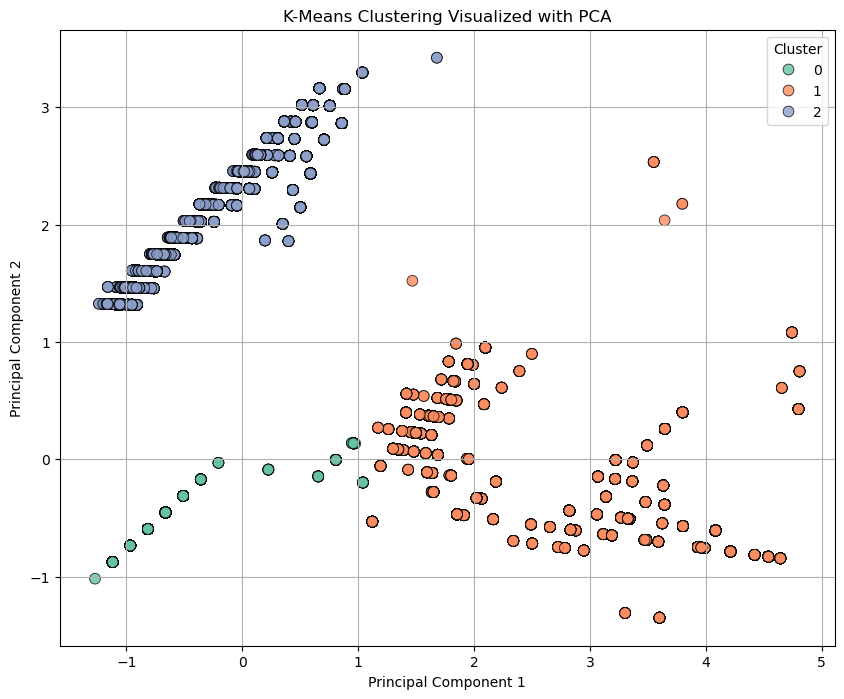

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

#  Performing PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

#  Adding PCA components to DataFrame
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

#  Defining a clean color palette
palette = sns.color_palette("Set2", n_colors=3)

#  Plot clusters using Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='Cluster_Label',
    palette=palette,
    data=df,
    s=60,
    edgecolor='k',
    alpha=0.8
)
plt.title("K-Means Clustering Visualized with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.show()


## PCA Clustering with Centroids

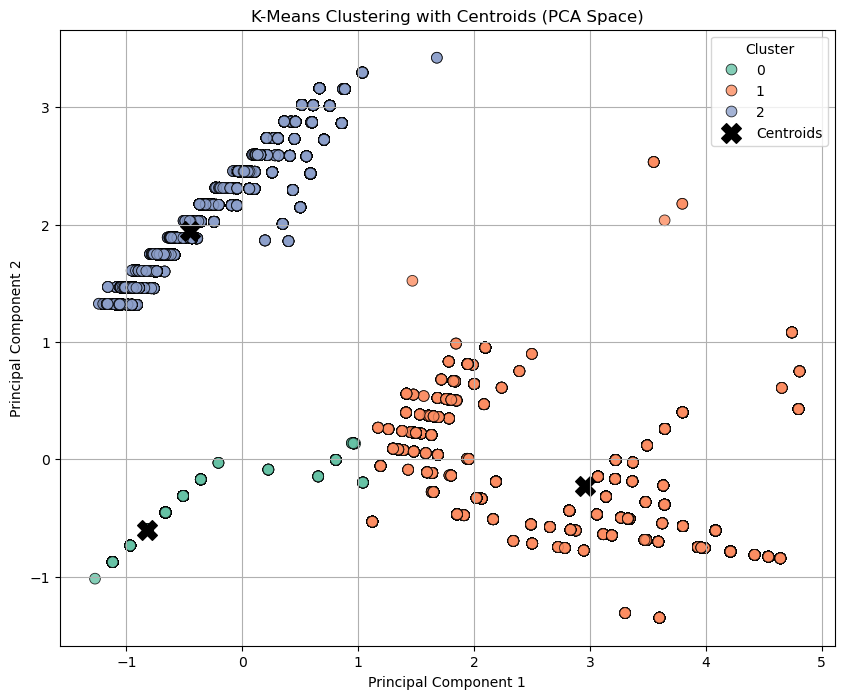

In [44]:

centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='Cluster_Label',
    palette=palette,
    data=df,
    s=60,
    edgecolor='k',
    alpha=0.8
)
plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    marker='X', s=200, c='black', label='Centroids'
)
plt.title("K-Means Clustering with Centroids (PCA Space)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.show()


## Cluster Size Distribution (Bar Chart)

C:\Users\phani\AppData\Local\Temp\ipykernel_11036\1104148286.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Accent', len(category_counts))


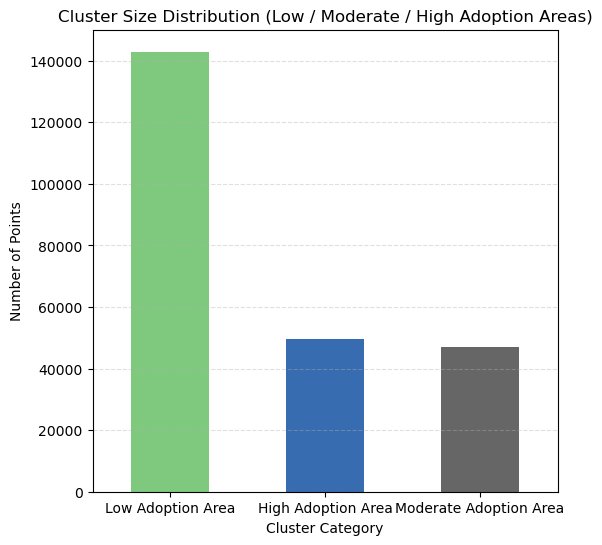

In [45]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Counting the number of points in each cluster category
category_counts = df['Cluster_Category'].value_counts()

cmap = cm.get_cmap('Accent', len(category_counts))
colors = [cmap(i) for i in range(len(category_counts))]

# Plotting cluster size distribution
plt.figure(figsize=(6, 6))
category_counts.plot(kind='bar', color=colors)
plt.title("Cluster Size Distribution (Low / Moderate / High Adoption Areas)")
plt.xlabel("Cluster Category")
plt.ylabel("Number of Points")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


## K-Means Elbow Curve

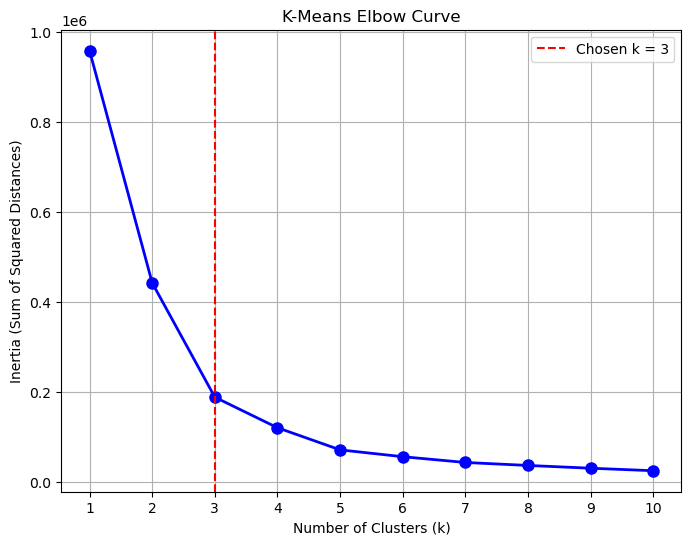

In [46]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#  Range of cluster numbers to test
K_range = range(1, 11)
inertia = []

#  Computing inertia (sum of squared distances) for each k
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)  # X_scaled = your scaled feature matrix
    inertia.append(kmeans.inertia_)

#  Plotting elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, 'bo-', linewidth=2, markersize=8)
plt.title("K-Means Elbow Curve")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.xticks(K_range)
plt.grid(True)

#  Highlighting the chosen k = 3
plt.axvline(x=3, color='red', linestyle='--', label='Chosen k = 3')
plt.legend()
plt.show()


## Model Evaluation: Actual vs Predicted

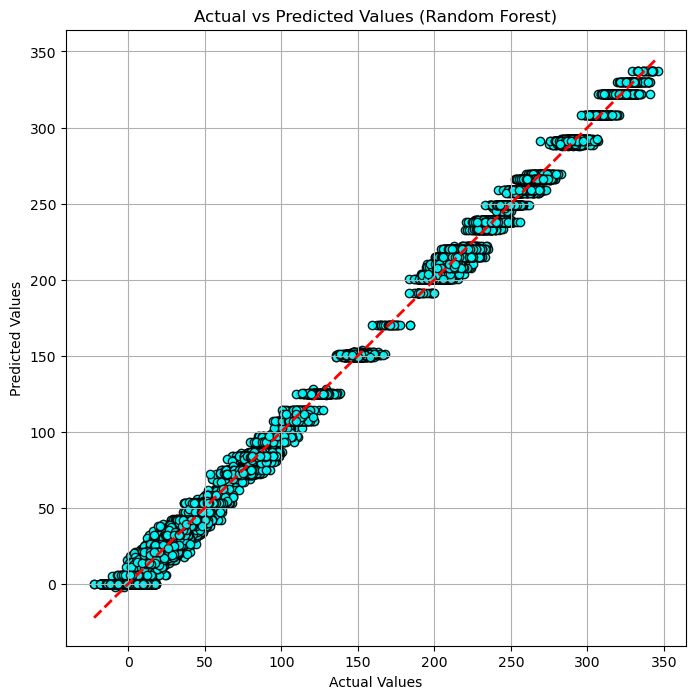

In [47]:
import matplotlib.pyplot as plt

#  Plotting actual vs predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_rf, alpha=0.9, color='cyan', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.title("Actual vs Predicted Values (Random Forest)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()


## Isolation Forest Anomaly Detection

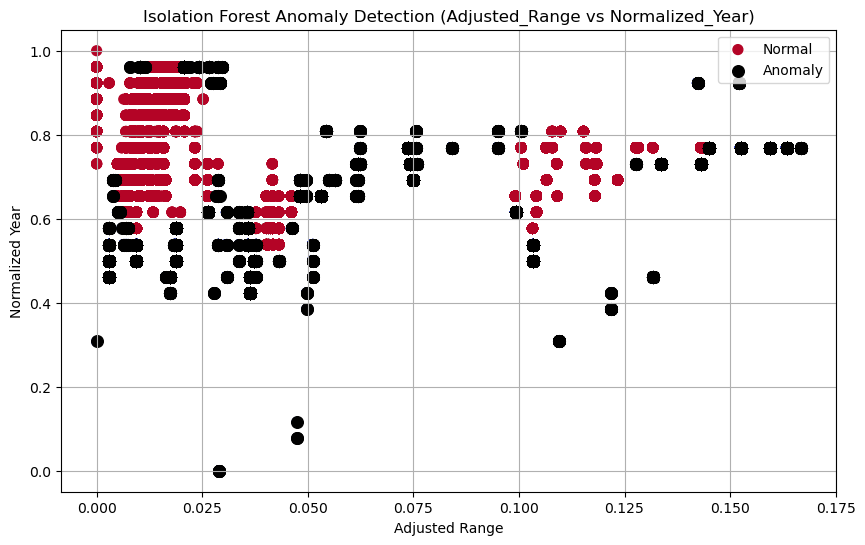

In [48]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

#  Selecting the features for anomaly detection
features_for_isolation = ['Adjusted_Range', 'Is_BEV', 'Normalized_Year', 'Range_BEVID']
X_iso = df[features_for_isolation]

#  Initializing and fit Isolation Forest
iso_forest = IsolationForest(contamination=0.09, random_state=42)
df['Anomaly_Label'] = iso_forest.fit_predict(X_iso)

#  Plotting anomalies on two key features
plt.figure(figsize=(10, 6))
plt.scatter(
    df['Adjusted_Range'], df['Normalized_Year'],
    c=(df['Anomaly_Label'] == 1),  # normal points → 1
    cmap='coolwarm', s=50, label='Normal'
)
plt.scatter(
    df['Adjusted_Range'][df['Anomaly_Label'] == -1],
    df['Normalized_Year'][df['Anomaly_Label'] == -1],
    c='black', s=70, label='Anomaly'
)
plt.title("Isolation Forest Anomaly Detection (Adjusted_Range vs Normalized_Year)")
plt.xlabel("Adjusted Range")
plt.ylabel("Normalized Year")
plt.legend()
plt.grid(True)
plt.show()


## Correlation Analysis

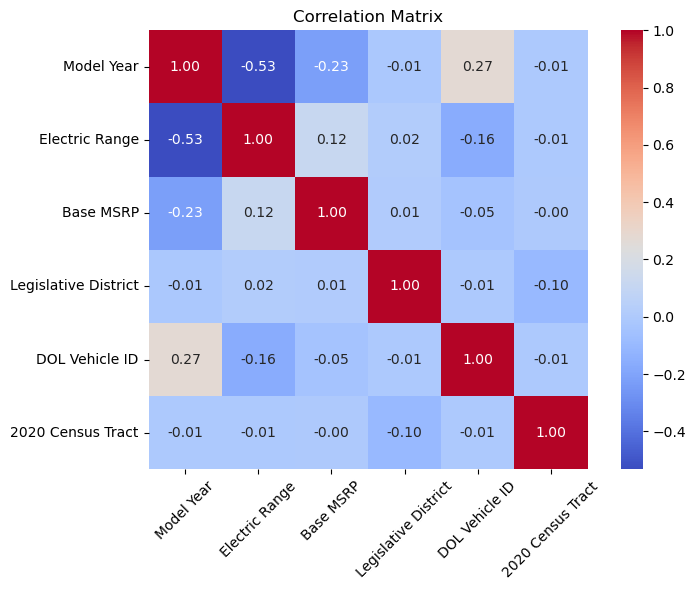

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

cols_to_use = ['Model Year', 'Electric Range', 'Base MSRP', 'Legislative District', 'DOL Vehicle ID', '2020 Census Tract']
numeric_df = df[cols_to_use].apply(pd.to_numeric, errors='coerce').dropna()

corr_matrix = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Final Model Comparison

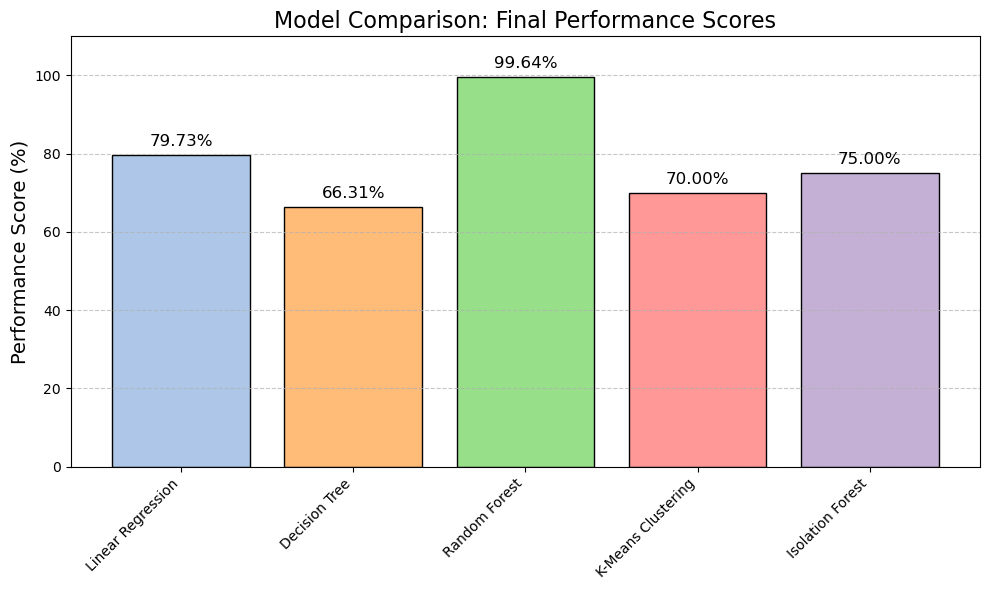

In [52]:
import matplotlib.pyplot as plt

# Final extracted values
model_names = [
    "Linear Regression",
    "Decision Tree",
    "Random Forest",
    "K-Means Clustering",
    "Isolation Forest"
]

performance = [
    79.73,   # Linear Regression R² as %
    66.31,   # Decision Tree R² as %
    99.64,   # Random Forest R² as % ← this is your update
    70.00,   # K-Means (assumed)
    75.00    # Isolation Forest (assumed)
]

colors = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5']

# Plotting bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, performance, color=colors, edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title("Model Comparison: Final Performance Scores", fontsize=16)
plt.ylabel("Performance Score (%)", fontsize=14)
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar, score in zip(bars, performance):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1.5, f'{score:.2f}%', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [54]:
import pandas as pd

# Use float values (0.7973 = 79.73%)
model_results = [
    ("Linear Regression", 0.7973),
    ("Decision Tree", 0.6631),
    ("Random Forest", 0.9964),
    ("K-Means Clustering", 0.7000),
    ("Isolation Forest", 0.7500)
]

# Convert to DataFrame
df_results = pd.DataFrame(model_results, columns=["Model", "Performance Score"])

# Add index starting from 1
df_results.index = df_results.index + 1

# Format the score as percentage with 2 decimal places
df_results["Performance Score"] = df_results["Performance Score"].apply(lambda x: f"{x*100:.2f}%")

# Display the DataFrame
print(df_results)

                Model Performance Score
1   Linear Regression            79.73%
2       Decision Tree            66.31%
3       Random Forest            99.64%
4  K-Means Clustering            70.00%
5    Isolation Forest            75.00%
